# Module 3 - Time Series Analysis

In [1]:
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from tslearn.clustering import TimeSeriesKMeans
from dtw import *
import sklearn
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
import stumpy

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from pyts.datasets import load_gunpoint
from pyts.transformation import BOSS
from pyts.classification import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

from pyts.classification import LearningShapelets
from pyts.datasets import load_gunpoint
from pyts.utils import windowed_view

from tqdm.auto import tqdm, trange

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



### Feature selection
Select the feature(s) you prefer and use it (them) as a time series. You can use the temporal information provided by the authors’ datasets, but you are also welcome in exploring the .mp3 files to build your own dataset of time series according to your purposes. You should prepare a dataset on which you can run time series clustering; motif/anomaly discovery and classification.

In [2]:
from load_data import load_data

X_train, y_train, X_test, y_test = load_data()

  0%|          | 0/106574 [00:00<?, ?it/s]

### Clustering
On the dataset created, compute clustering based on Euclidean/Manhattan and DTW distances and compare the results. To perform the clustering you can choose among different distance functions and clustering algorithms. Remember that you can reduce the dimensionality through approximation. Analyze the clusters and highlight similarities and differences.
Analyze the dataset for finding motifs and/or anomalies. Visualize and discuss them and their relationship with other features.

No handles with labels found to put in legend.


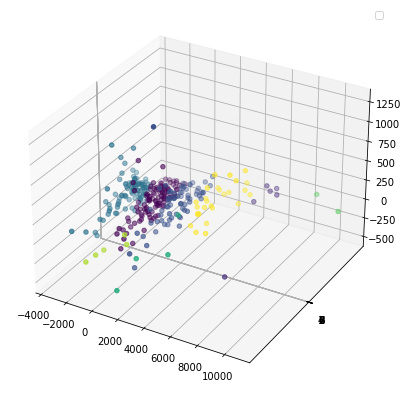

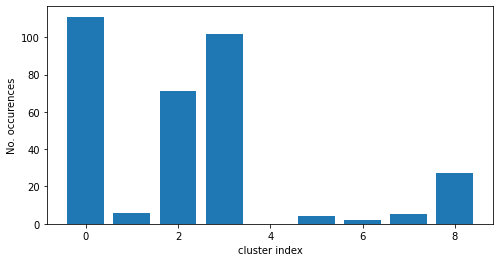

No handles with labels found to put in legend.


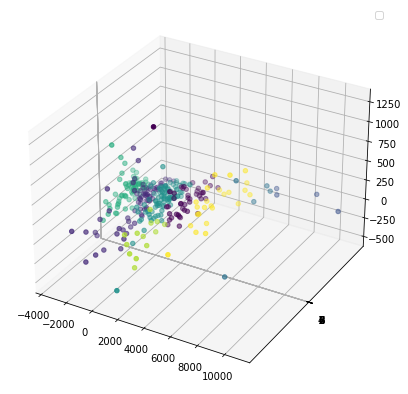

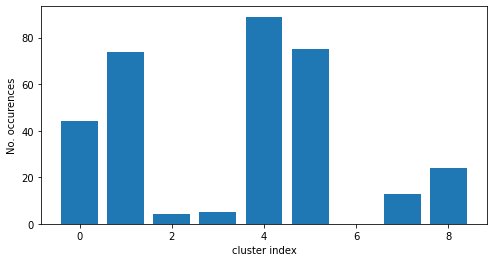

In [17]:
n_clusters = 9
for metric in ['euclidean', 'dtw']:
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=5)
    kmeans.fit(X_train)
    pred = kmeans.predict(X_test) 
    
    pca = PCA(n_components=3)
    pca.fit(X_train)
    tr = pca.transform(X_test)
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter3D(tr[:, 0], -tr[:, 1], tr[:, 2], c = pred)
    
    plt.yticks(list(range(n_clusters)))
    plt.legend()
    plt.show()


    labels = list(sorted(list(set(pred))))
    plt.bar(labels, [len([1 for el in pred if el==l]) for l in labels])
    plt.xlabel('cluster index')
    plt.ylabel('No. occurences')
    plt.show()
    

Anomaly detection

1308  ->  1178
1308  ->  1178
1308  ->  1178


<Figure size 576x288 with 0 Axes>

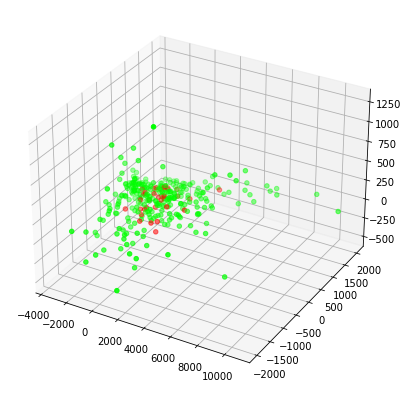

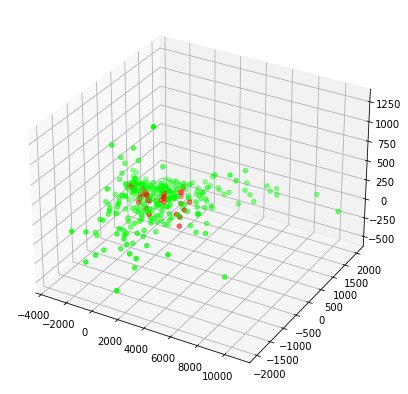

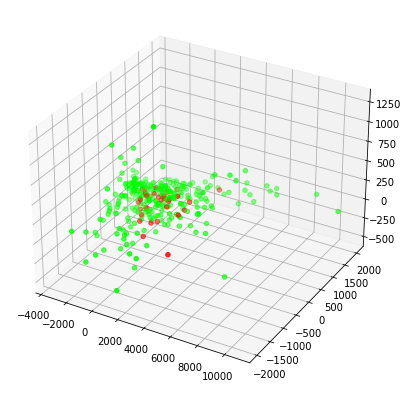

In [12]:
plt.figure(figsize=(8, 4))
md_range = range(1, 21)#71)
n_trials = 5
outlier_fraction = 0.1
#evaluate_clf(DecisionTreeClassifier, [{'max_depth': i} for i in md_range], X_train, y_train, X_test, y_test, n_trials)

for od_clf in [IsolationForest(random_state=0), LocalOutlierFactor(novelty=True), EllipticEnvelope()]:
    od_clf.fit(X_train)
    decisions_train = od_clf.decision_function(X_train)
    decisions_test = od_clf.decision_function(X_test)
    treshold = np.sort(decisions_test)[int((1.-outlier_fraction)*len(decisions_test))]
    pred = np.array([(np.array([1., 0., 0.]) if el > treshold else np.array([0., 1., 0.])) 
                     for el in decisions_test])
    inliers_train = np.argsort(decisions_train)[int(outlier_fraction*len(X_train)):]
    inliers_test = np.argsort(decisions_test)[int(outlier_fraction*len(X_test)):]
    X_test_OD, y_test_OD = X_test[inliers_test], y_test[inliers_test]
    print(len(X_train), ' -> ', len(X_train_OD))
    
    pca = PCA(n_components=3)
    pca.fit(X_train)
    tr = pca.transform(X_test)
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter3D(tr[:, 0], -tr[:, 1], tr[:, 2], c = pred)


No handles with labels found to put in legend.


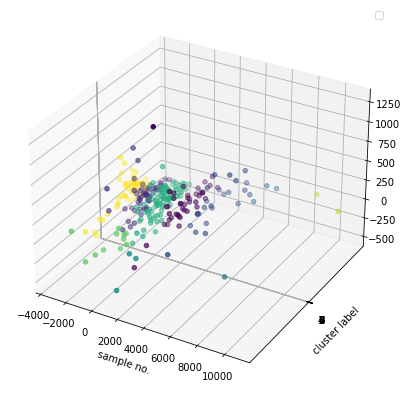

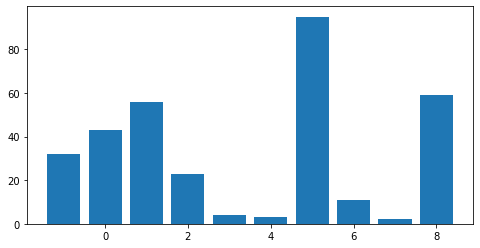

No handles with labels found to put in legend.


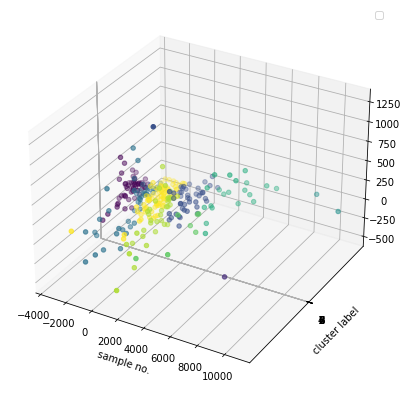

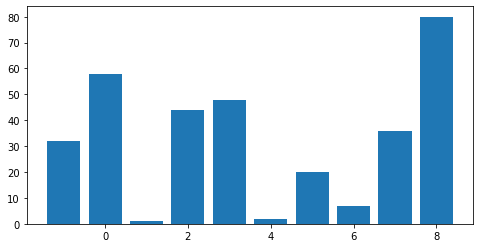

In [16]:
n_clusters = 9
for metric in ['euclidean', 'dtw']:
    kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric=metric, max_iter=5)
    kmeans.fit(X_train_OD)
    pred = kmeans.predict(X_test_OD) 
    
    pca = PCA(n_components=3)
    pca.fit(X_train)
    tr = pca.transform(X_test_OD)
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter3D(tr[:, 0], -tr[:, 1], tr[:, 2], c = pred)

    plt.yticks(list(range(n_clusters)))
    plt.legend()
    plt.show()
    
    labels = list(sorted(list(set(pred))))
    plt.bar([-1]+labels, [len(X_test)-len(pred)]+[len([1 for el in pred if el==l]) for l in labels])
    plt.show()

### Motifs discovery

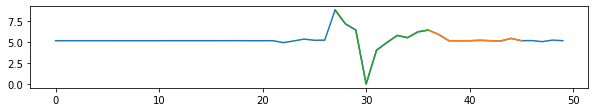

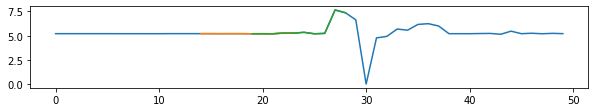

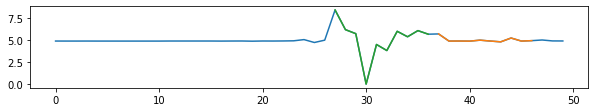

In [22]:
def log_t(x):
    return np.log(x-np.min(x, axis=0)+1)

m = 10
for x in X_train[np.random.choice(np.arange(len(X_train)), size=3)]:
    plt.figure(figsize=(10, 1.5))
    mps = stumpy.stump(x, m)
    idx = np.argsort(mps[:, 0])
    #print(idx)
    plt.plot(log_t(x))
    for idx_ in idx[:2]:
        plt.plot(list(range(idx_, idx_+m)), log_t(x)[idx_:idx_+m])
    plt.show()
    

### Classification
Solve the classification task on the time series dataset(s) and evaluate each result. In particular, you should use shapelet-based classifiers. Analyze the shapelets retrieved and discuss if there are any similarities/differences with motifs and/or shapelets.

N.B. When “solving the classification task”, remember, (i) to test, when needed, different criteria for the parameter estimation of the algorithms, and (ii) to evaluate the classifiers (e.g., Accuracy, F1, Lift Chart) in order to compare the results obtained with an imbalanced technique against those obtained from using the “original” dataset.

In [23]:
f1 = sklearn.metrics.make_scorer(lambda X, y: sklearn.metrics.f1_score(X, y, average='macro'))

In [ ]:
n_trials = 5
scores = []
xs = np.arange(0.025,0.525, 0.025)
for n_shapelets in tqdm(xs):
    scores_ = []
    for i in range(n_trials):
        clf = LearningShapelets(n_shapelets, random_state=i+10)
        clf.fit(np.log(X_train-np.min(X_train, axis=0)+1), y_train)
        scores_.append(f1(clf, np.log(X_test-np.min(X_test, axis=0)+1), y_test))

    scores.append((np.mean(scores_), np.std(scores_)))
scores = np.stack(scores)
print(scores.shape)
plt.fill_between(xs, scores[:,0]-scores[:,1], scores[:,0]+scores[:,1], alpha=0.3)
plt.plot(xs, scores[:,0])
plt.xlabel('No. shapelets')
plt.ylabel('F1 score')
plt.show()

In [ ]:
algorithms = [(GaussianNB, {}, 1), 
              (LogisticRegression, {'max_iter':1000, 'C': 0.55}, 1),
              (SVC, {'max_iter':1000, 'C':2.55}, 1), 
              (MLPClassifier, {'max_iter':1000, 'alpha': 0.05012}, 5)]

for alg, kwargs, n_trials in algorithms:
    for wor_s in [4, 8, 12]:
        scores = []
        xs = list(range(wor_s+1,50))
        for win_s in tqdm(xs):
            scores_ = []
            for ti in range(n_trials):
                boss = BOSS(word_size=wor_s, window_size=win_s, norm_mean=True, drop_sum=True, sparse=False)

                clf = make_pipeline(boss, alg(**kwargs))
                clf.fit(X_train, y_train)
                scores_.append(f1(clf, X_test, y_test))
            scores.append((np.mean(scores_), np.std(scores_)))
        scores = np.stack(scores)
        plt.fill_between(xs, scores[:,0]-scores[:,1], scores[:,0]+scores[:,1], alpha=0.3)
        plt.plot(xs, scores[:,0], label=f'BOSS word_size={wor_s}')
    plt.title(f'BOSS + {alg.__name__}')
    plt.xlabel('BOSS window size')
    plt.ylabel('F1 score')
    plt.legend()
    plt.show()
    
            